In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/1.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(720, 1280, 3)


# Segmentation with DeepLab v3+

- Atrous convolution은 기존 convolution과 다르게, 필터 내부에 빈 공간을 둔 채로 연산하여 기존 convolution과 동일 파라미터를 유지하여 연산량을 유지하며 receptive field를 넓게 가져갈 수 있다.


- Depthwise Separable Convolution 는 convolution 연산시 채널을 분리해여 Depthwise하게 연산한 후 1x1 convolution을 통해 channel을 1로 만든다
  
  -> Depthwise separable convolution은 기존 convolution filter가 spatial dimension과 channel dimension을 동시에 처리하던 것을 따로 분리시켜 각각 처리한다고 볼 수 있다

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size, interpolation=cv2.INTER_AREA)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
      
print('z')

z


In [4]:
# define model and download & load pretrained weight
'''
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)
'''


model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(720, 1280, 3) (288, 513, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- img_orig 를 넣고 돌린 결과의 seg_map.max()는 당연히 나다 (person : 15)

- seg_map 을 통해 사람만 추출~~

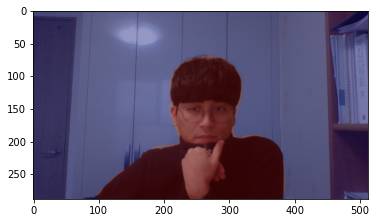

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

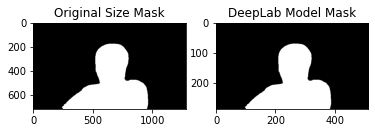

In [8]:
# resize된 mask original size로 다시 resize

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

- 배경을 흐리게 하기 위해서 세그멘테이션 마스크를 이용해서 배경만 추출

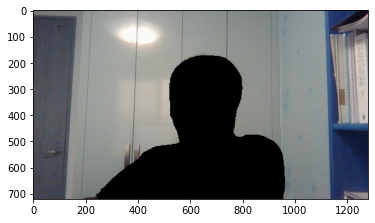

In [9]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

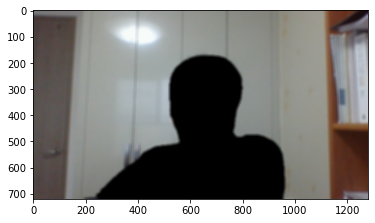

In [10]:
# blur처리

img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

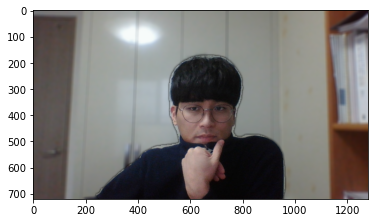

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Problem

- seg_mask 영역을 넘어 가장자리부분에 테두리가 생김

- blur 처리 할 때 median blur method사용하고 downsample resize할 때 보간을 INTER_AREA upsample resize때 INTER_CUBIC 사용했더니 어느정도 해결~
  -> but 완전히 해결하지는 못함 


- resize시 세심하게 건드려야 할것같은데 (downsample 전에 미리 이미지 비율을 맞춰 crop하는 식으로) 더이상 건드리기 귀찮다~
- 그리고 blur시킬때 커널사이즈를 크게할수록 두드러지게 나타난다 개같은거

In [12]:
'''
new_mask = np.where(img_bg==255, img_orig, 0)

plt.imshow(cv2.cvtColor(new_mask, cv2.COLOR_BGR2RGB))
plt.show()
'''

'\nnew_mask = np.where(img_bg==255, img_orig, 0)\n\nplt.imshow(cv2.cvtColor(new_mask, cv2.COLOR_BGR2RGB))\nplt.show()\n'

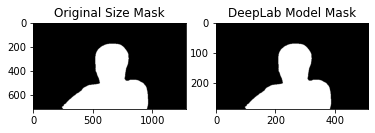

In [13]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_CUBIC)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

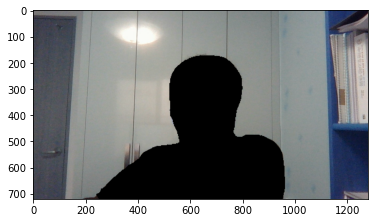

In [14]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

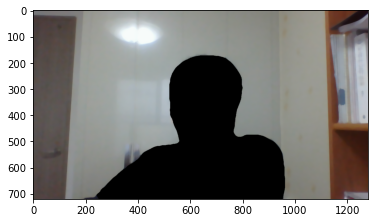

In [15]:
img_bg_blur = cv2.medianBlur(img_bg, 13)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

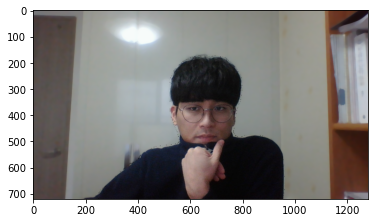

In [16]:
img_concat2 = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/1_portrait_mode.jpg'

cv2.imwrite(img_path, img_concat2)

True

## 배경이 배경다운 사진으로 test

In [18]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/3.JPG'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig2 = cv2.imread(img_path) 

In [19]:
img_resized, seg_map = MODEL.run(img_orig2)
print (img_orig2.shape, img_resized.shape, seg_map.max())

(2560, 1920, 3) (513, 384, 3) 15


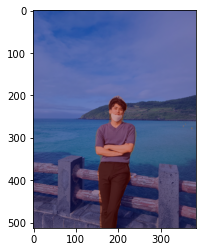

In [20]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

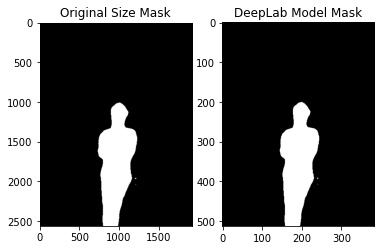

In [21]:
img_mask_up = cv2.resize(img_mask, img_orig2.shape[:2][::-1], interpolation=cv2.cv2.INTER_CUBIC)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

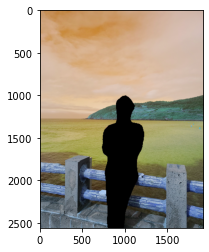

In [22]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig2, img_bg_mask)
plt.imshow(img_bg)
plt.show()

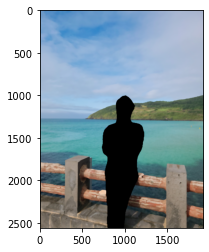

In [23]:
img_bg_blur = cv2.medianBlur(img_bg, 15)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

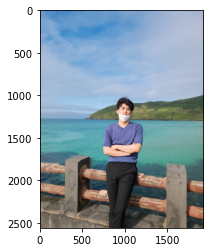

In [24]:
img_concat = np.where(img_mask_color==255, img_orig2, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/3_portrait_mode.jpg'

cv2.imwrite(img_path, img_concat)

True

## 고양이도 해볼까~

In [26]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig3 = cv2.imread(img_path) 

In [27]:
img_resized, seg_map = MODEL.run(img_orig3)
print (img_orig3.shape, img_resized.shape, seg_map.max())

(4032, 3024, 3) (513, 384, 3) 8


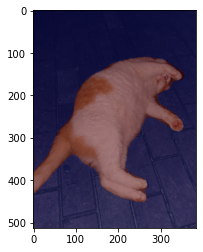

In [28]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

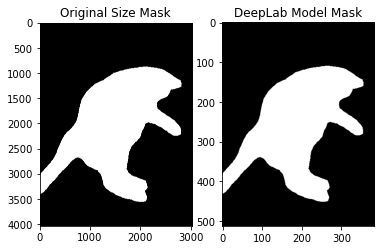

In [29]:
img_mask_up = cv2.resize(img_mask, img_orig3.shape[:2][::-1], interpolation=cv2.cv2.INTER_CUBIC)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

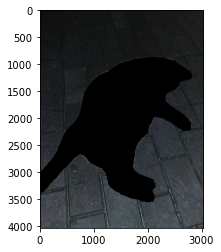

In [30]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig3, img_bg_mask)
plt.imshow(img_bg)
plt.show()

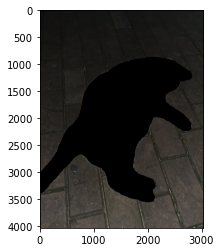

In [31]:
img_bg_blur = cv2.medianBlur(img_bg, 15)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

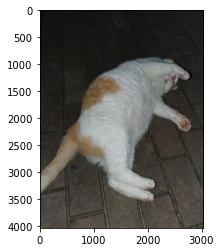

In [32]:
img_concat = np.where(img_mask_color==255, img_orig3, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [33]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_portrait_mode.jpg'

cv2.imwrite(img_path, img_concat)

True

- 고양이가 바닥에 붙어있어서 블러링된게 구분이 안간다

## 다른 고양이 test

In [34]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig3 = cv2.imread(img_path) 

In [35]:
img_resized, seg_map = MODEL.run(img_orig3)
print (img_orig3.shape, img_resized.shape, seg_map.max())

(4032, 3024, 3) (513, 384, 3) 8


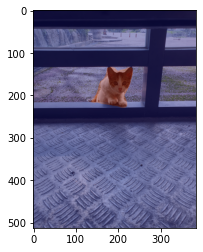

In [36]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

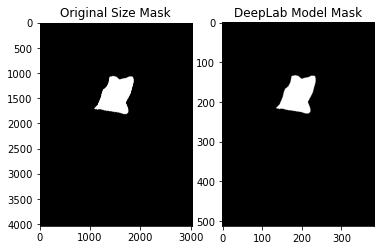

In [37]:
img_mask_up = cv2.resize(img_mask, img_orig3.shape[:2][::-1], interpolation=cv2.cv2.INTER_CUBIC)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

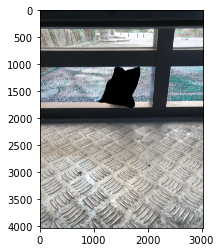

In [38]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig3, img_bg_mask)
plt.imshow(img_bg)
plt.show()

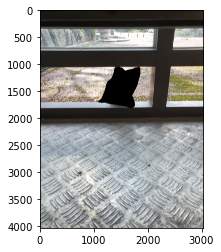

In [39]:
img_bg_blur = cv2.medianBlur(img_bg, 15)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

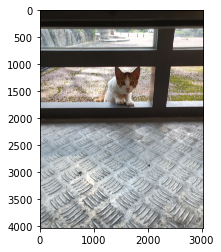

In [40]:
img_concat = np.where(img_mask_color==255, img_orig3, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [41]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2_portrait_mode.jpg'

cv2.imwrite(img_path, img_concat)

True

- 배경이 애메해서 별 특별한 성과없다 : 고양이가 배경나오도록 사진찍게 가만히있을리가없지

- 크로마키 모드는 안할란다~

- Depth Prediction without the Sensors도 이 프로젝트의 범위를 넘어서는것이라 생각해서 안할란다~

## 개인지 뭔지 뭔지모를 사진은 뭐로 판단하나 궁금해서 해봄 

In [42]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sth.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 

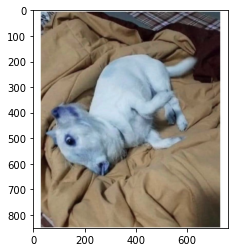

In [43]:
plt.imshow(img_orig)

- 볼때마다 뭔지 햇갈린닼ㅋㅋㅋ

In [44]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sth.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig3.shape, img_resized.shape, seg_map.max())

(4032, 3024, 3) (513, 458, 3) 12


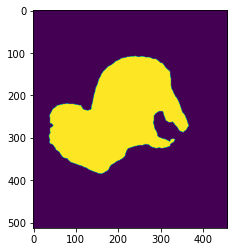

In [45]:
plt.imshow(seg_map)

In [46]:
LABEL_NAMES[12]

'dog'

# 오늘의 결론
- 인공지능이 사람보다 낫다.....